In [1]:
import torch
from torch import nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Introduction to Neural Networks

In machine learning, classification tasks are among the most common problems. A classification task consists of assigning a class to a given object. For example, deciding whether a photo shows a dog or a cat, determining whether a biopsy image is cancerous or not, or assigning a category to a web article are all examples of classification problems.  

In general, we can distinguish three main types of classification problems:

1. **Binary classification**: here, the target variable can take only one of two possible values (yes/no, true/false, dog/cat, etc.). These are the simplest classification problems, but also among the most frequent in real-world applications.  
2. **Multi-class classification**: in this case, the target variable can take more than two possible values. For instance, in sentiment analysis, a tweet might be classified as positive, negative, or neutral.  
3. **Multi-label classification**: here, the target can be assigned multiple labels simultaneously. For example, when classifying the themes of a web article, we might assign more than one label, such as *science*, *mathematics*, and so on.  

Classification problems can be solved with traditional machine learning algorithms, such as *Decision Trees*, *Logistic Regression*, or *Naive Bayes*. In this notebook, however, we will focus on more advanced approaches: *Neural Networks*. We will build a simple neural network for classification from scratch using PyTorch, while also briefly discussing the mathematics behind the architecture.  

In particular, we will cover:  
- The typical architecture of a neural network;  
- How to build a neural network model with PyTorch from scratch, including the loss function, the optimizer, and the training loop;  
- How to train the model and make predictions on unseen data;  
- How to improve the model from an architectural perspective.  


## Make classification data

First of all, we need a classification problem! Let's stick to example shown in the *Zero to Mastery* course, i.e we use the `make_circles` function from `sklearn` to generate two circles of different radius:

In [2]:
# Create circles, 
X, y = make_circles(1000, noise = 0.03, random_state = 42)

In [3]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [4]:
X.shape

(1000, 2)

In [5]:
y[:5]

array([1, 1, 1, 1, 0])

In [6]:
y.shape

(1000,)

We see that $X$ is an array of shape (1000, 2), i.e. we have 1000 points with two coordinates, say $X_1, X_2$. In contrast, $y$ is an array of shape (1000,1) with 0, 1 values. Let's make a pandas dataframe from these two arrays and plot the corresponding circle.

In [7]:
# Create a pandas dataframe
df_circles = pd.DataFrame(
    {
        "X_1": X[:,0], 
        "X_2": X[:,1],
        "label": y
    }
)

In [8]:
df_circles

,X_1,X_2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


Text(0, 0.5, '$X_2$')

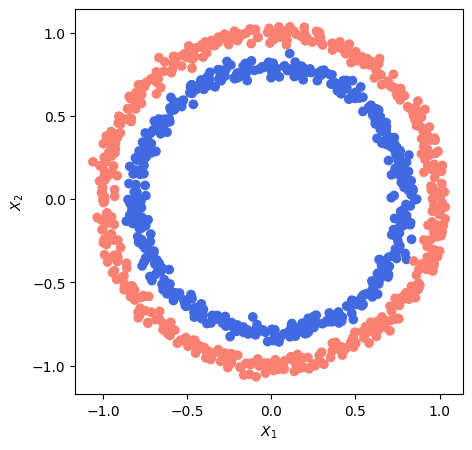

In [9]:
# Plotting the circles:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_circles["X_1"], df_circles["X_2"], c=df_circles["label"].map(lambda x: "royalblue" if x == 1 else "salmon"))
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")

In [10]:
# Let's check different labels
df_circles["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

It looks like we have our classification problem set up: given a pair of coordinates $X_1$ and $X_2$, we need to classify the corresponding point into "red" or "blue", i.e. understanding whether it belongs to the inner or the outer circle. Of course, this is just a **toy dataset**, a dataset that we are using just for testing our model architecture and to make practice. 

### Input and Output Layers

But what is a neural network?  

Informally, we can think of a neural network as a **black box**: it takes some input values and produces some output values. All the complexity of the network lies inside this box, which is nothing more than a sequence of mathematical operations applied to the input.  

The reason it is called *neural* is that its structure was inspired—at least loosely—by how the human brain works. The box is organized into **layers**, often referred to as *hidden layers*. Each layer is made up of units called **neurons**, and each neuron performs a simple mathematical operation on its inputs. By stacking and connecting many neurons across multiple layers, the network can transform raw input data step by step until it produces an output.  

In this sense, a neural network resembles the propagation of a signal in the brain:  
- an **input signal** (the input values) arrives,  
- the **neurons** process this signal through a series of transformations,  
- an **output signal** is produced (in our case, the predicted target variable).  

Below, you can see a diagram that visually represents the structure of a neural network.  

![NN-Architecture](../images/nn-architecture.png)
---

Before we dive into the internal structure (the hidden layers), we first need to understand how to define and represent the **input** and **output layers** in PyTorch.  

A key point to grasp is the **shape** of these layers. Since PyTorch models are built on tensors, most of the common errors you will face come from mismatched tensor shapes during operations. This is, by far, the most frequent beginner mistake—and you will almost certainly run into it yourself. However, by constantly paying attention to the shape of your data and familiarizing yourself with it, you will gradually reduce these errors and become more confident in debugging them.


In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


We see that the shape of a single example of features is $2$, meaning that we have two feature values per record. Hence, a tensor representing the input values will have the second dimension equal to 2. On the other hand, one sample of $y$ has "0 dimensions", meaning that it's a **scalar value**.

Now we need to:
1. Turn out data into *tensors*;
2. Split our data into training and test sets

In [12]:
# Turning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
# Let's use the train_test_split() from sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, # 20% test, 80% train
    random_state=42
) # make the random split reproducible

In [15]:
# Checking dimensions
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building the model

Now that we have prepared our dataset and split it into training and test sets, we are ready to build a classification model with PyTorch. The main steps are:

- Setting up device-agnostic code, as we saw in the `introduction-to-tensors` notebook, so that our model can run on either CPU or GPU if available  
- Building a model using `nn.Module`  
- Defining a loss function and an optimizer  
- Creating a training loop  

Let’s start by setting up the device-agnostic code:

In [16]:
# Make device agnostic code (on MacBook)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

In [17]:
device

device(type='mps')

Our model needs to handle the input and output shapes of `X` and `y`. In particular, we have seen that `X` consists of two features, while `y` is the target variable, represented by a single label. Let’s create a model with the following characteristics:

1. It should be a subclass of `nn.Module`  
2. It should include two layers, specifically *linear layers* created with PyTorch’s `nn.Linear` constructor, capable of handling the input and output shapes of `X` and `y`  
3. It should define a `forward()` method that implements the forward pass of the model  
4. Finally, we will instantiate the model class and move it to the target `device`  

In [18]:
# Building a simple Neural Network for classification
class CircleModel_v0(nn.Module):
    def __init__(self):
        # inheritance from nn.Module 
        super().__init__()

        # Defining layers as class attributes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # take 2 input features and output 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # take 5 input features and output 1 feature (y)

        
    # Define the forward metho
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x))        

In [19]:
# 4. Create an instance of the model and send it to target device
circlemodel_v0 = CircleModel_v0().to(device)

In [20]:
circlemodel_v0

CircleModel_v0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

So what is happening here? We have built a neural network with one hidden layer consisting of 5 units (or neurons). As we can see above, the first linear layer takes 2 input features and produces 5 outputs. This allows the model to represent the data using 5 numbers instead of just 2, which can potentially lead to better performance. Of course, we also need an additional layer to map those 5 features down to a single output, which corresponds to our target variable.

The number of hidden neurons in a neural network is called a **hyperparameter**, since it is something we can choose and tune depending on how the model performs. In general, having more neurons can give the model more capacity, but this is not a strict rule. The “right” number of neurons depends on the problem at hand, the size and complexity of the dataset, the available computational resources, and other factors.

When we have *sequential* layers as above, we can build the model with a simpler sintax using the `nn.Sequential` module, which already implements a forward method that performs a computation of the input data through the layers in the order they appear:

In [21]:
# Defining a sequential nn and sending it to device
sequential_circlemodel = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [22]:
sequential_circlemodel

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Before writing a training loop, let's see how to use the untrained model and what data it generates:

In [23]:
# Make predictions with the untrained model --> Notice that we have to send X to the given device!
untrained_preds = circlemodel_v0(X_test.to(device))

In [24]:
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])


In [25]:
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


First 10 predictions:
tensor([[-0.1772],
        [-0.2157],
        [-0.0356],
        [-0.2175],
        [ 0.0286],
        [ 0.0046],
        [-0.1549],
        [-0.1031],
        [-0.0386],
        [-0.2176]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Ok, there is something going on here. Indeed, our test labels are just 0/1 number while our NN outputs data between 0 and 1. So we need some additional steps to fix this. However, let's define a loss function and an optimizer before. 

In the `pytorch-workflow` notebook, we introduced the MAE loss function for regression problems. For classification problems, a commonly used loss function is **binary cross-entropy**. Let’s briefly explain what this loss function is.

If you are familiar with physics, you know that **entropy** is a thermodynamic quantity which—roughly speaking—can be seen as a measure of disorder within a system. For example, when matter undergoes a state change (e.g. ice → liquid water), its entropy typically changes: ice has lower entropy, or “less disorder,” since H₂O molecules are arranged in a well-defined crystalline structure. In contrast, in liquid water, the molecules are free to move, making the overall state more disordered.

This physical concept was later adopted in information theory to describe the uncertainty or “randomness” of a set of outcomes. Formally, the entropy of a discrete random variable is defined as:
$$
H(X) = - \sum_i p(x_i)\log(p(x_i))
$$
where $p$ is the probability distribution over the random variable $X$, and $x_i$ is a possible outcome.  

Entropy can thus be interpreted as a measure of uncertainty: higher entropy means greater uncertainty, and lower entropy means less. Equivalently, entropy quantifies the expected amount of information required to describe the state of the variable, given its probability distribution.

In machine learning, entropy provides intuition about how “confident” or “uncertain” a model’s predictions are. In classification problems, we are particularly interested in comparing two probability distributions:  
- the true distribution of the target variable,  
- the predicted distribution produced by our model.  

Of course, we do not know the *true* probability distribution of the target variable—if we did, the classification problem would already be solved. Instead, we approximate it from the labels in the dataset, and then we compare it to the distribution produced by the model’s predictions.  

The measure of dissimilarity between these two distributions is called **cross-entropy**, defined as:
$$
H(p(X), q(X)) = -\sum_i p(x_i)\log(q(x_i))
$$
Here, $p$ represents the true distribution and $q$ the predicted distribution. Intuitively, cross-entropy tells us how well the predictions $q$ approximate the true distribution $p$.  

The *binary* version is the special case of binary classification, where the target variable can only take two values: 0 or 1. For each data point, we know the true label $y_i$, and the model outputs a predicted probability $q(x_i)$. The binary cross-entropy is then defined as:
$$
BCE(y, q(X)) = -\sum_{i=1}^n \left( y_i \log(q(x_i)) + (1-y_i)\log(1-q(x_i))\right)
$$
This function penalizes the model more strongly when it assigns low probability to the correct class, encouraging it to make confident and accurate predictions.

In PyTorch there are two implementations of BCE:
1. `torch.nn.BCELoss()`: it creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2.  `torch.nn.BCEWithLogitsLoss()`:  this is the same as above except it has a sigmoid layer (`nn.Sigmoid`) built-in.
According to the pytorch documentation, the latter is numerically more stable so we will use this loss function.

For the optimizer, we can still use the SGD or the Adam optimizer. Let's pick the SDG for this model:

In [26]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=circlemodel_v0.parameters(), 
                            lr=0.1)

Before writing the training loop, we need to define an evaluation metric. During training, the model is optimized to minimize the loss function—in our case, the binary cross-entropy. However, at the end of training, we also need a metric to assess how good the model’s predictions are.  

The simplest and most commonly used metric for classification is **accuracy**, which is computed as the number of correct predictions divided by the total number of predictions.  

A PyTorch (tensor-based) implementation is the following:

In [34]:
# Tensorial evaluation of accuracy
def accuracy_fn(y_true, y_preds):
    # torch.eq() calculates where two tensors are equal
    correct = torch.eq(y_true, y_preds).sum().item() 
    acc = (correct / len(y_preds)) * 100 
    return acc

Above, we noticed that the untrained predictions are not simple 0/1 labels as we might expect. Why is that? Let’s take a closer look at what our neural network is actually doing.  

If $\boldsymbol{X}$ is our training set, the outputs $y$ are computed as:
$$
y = \boldsymbol{X} \cdot \boldsymbol{W}^T + \boldsymbol{B}
$$
This is the fundamental equation governing a simple sequential neural network like the one we defined. (We will explore this equation in more detail in the appendix.)  

In essence, the outputs are obtained by multiplying the input features with a weight matrix $\boldsymbol{W}$—whose values will be optimized during training—and then adding a bias term $\boldsymbol{B}$. As a result, the raw outputs are not constrained to be between 0 and 1.  

To handle this, we typically pass the raw outputs—often called **logits**—through an additional function. For binary classification, the most common choice is the **sigmoid function**, $S$, which squashes the values into the range $[0,1]$. We can then interpret the result as a probability and apply a simple decision rule:
1. If $S(y) \geq 0.5$, the model predicts class 1  
2. If $S(y) < 0.5$, the model predicts class 0  


In [35]:
untrained_preds[:10]

tensor([[-0.1772],
        [-0.2157],
        [-0.0356],
        [-0.2175],
        [ 0.0286],
        [ 0.0046],
        [-0.1549],
        [-0.1031],
        [-0.0386],
        [-0.2176]], device='mps:0', grad_fn=<SliceBackward0>)

In [36]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(untrained_preds)
y_pred_probs[:10]

tensor([[0.4558],
        [0.4463],
        [0.4911],
        [0.4458],
        [0.5072],
        [0.5012],
        [0.4614],
        [0.4742],
        [0.4904],
        [0.4458]], device='mps:0', grad_fn=<SliceBackward0>)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function:

In [37]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

In [38]:
y_preds[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='mps:0', grad_fn=<SliceBackward0>)

Nice, we are now ready to write our training loop:

In [39]:
# Defining epochs
epochs = 500

In [41]:
# TRAINING LOOP
torch.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### TRAINING

    # This command put the model in training mode
    circlemodel_v0.train()

    # 1. Pass the training data through the forward() method of the model
    y_logits = circlemodel_v0(X_train).squeeze() # squeeze to remove the extra dimension
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss and accuract
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_preds) 

    # 3. Zero grad of the optimizer --> we zero the gradients since they accumalate at each epochs
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### TESTING
    # Put the model in evaluation mode
    circlemodel_v0.eval()

    # Make the inference
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_logits = circlemodel_v0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_preds)

        # Print out what's happening every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69567, Accuracy: 46.88% | Test loss: 0.69210, Test acc: 49.50%
Epoch: 10 | Loss: 0.69491, Accuracy: 47.50% | Test loss: 0.69165, Test acc: 52.00%
Epoch: 20 | Loss: 0.69450, Accuracy: 48.12% | Test loss: 0.69153, Test acc: 51.00%
Epoch: 30 | Loss: 0.69424, Accuracy: 48.38% | Test loss: 0.69153, Test acc: 53.00%
Epoch: 40 | Loss: 0.69407, Accuracy: 48.88% | Test loss: 0.69159, Test acc: 53.00%
Epoch: 50 | Loss: 0.69393, Accuracy: 48.75% | Test loss: 0.69167, Test acc: 52.50%
Epoch: 60 | Loss: 0.69383, Accuracy: 49.00% | Test loss: 0.69176, Test acc: 53.00%
Epoch: 70 | Loss: 0.69374, Accuracy: 48.62% | Test loss: 0.69186, Test acc: 54.50%
Epoch: 80 | Loss: 0.69367, Accuracy: 49.00% | Test loss: 0.69195, Test acc: 54.50%
Epoch: 90 | Loss: 0.69361, Accuracy: 48.50% | Test loss: 0.69205, Test acc: 53.00%
Epoch: 100 | Loss: 0.69356, Accuracy: 49.12% | Test loss: 0.69213, Test acc: 54.00%
Epoch: 110 | Loss: 0.69351, Accuracy: 49.00% | Test loss: 0.69222, Test acc: 54.00%
Epo

What’s going on here? It seems that our model’s performance is very poor, and it even degrades as the training loop progresses. In practice, the model is predicting the target labels no better than random guessing. Why might this be happening? To gain more insight, let’s visualize the decision boundary learned by the model:

In [42]:
# Create a meshgrid that covers the data space
x_min, x_max = df_circles["X_1"].min() - 0.5, df_circles["X_1"].max() + 0.5
y_min, y_max = df_circles["X_2"].min() - 0.5, df_circles["X_2"].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

In [47]:
# Put the grid in the right shape for the model
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

In [48]:
grid_tensor = grid_tensor.to(device)

In [50]:
# Get model predictions (logits → sigmoid → probabilities)
with torch.no_grad():
    point_preds = torch.sigmoid(circlemodel_v0(grid_tensor)).to("cpu").numpy().reshape(xx.shape)

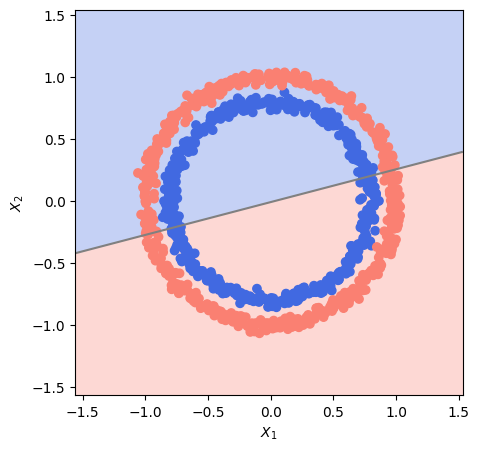

In [57]:
# Plot the decision regions
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(xx, yy, point_preds, levels=[0, 0.5, 1], alpha=0.3, colors=["salmon", "royalblue"])

# Also plot the decision boundary line (at probability = 0.5)
ax.contour(xx, yy, point_preds, levels=[0.5], colors="grey", linewidths=1.5)

ax.scatter(df_circles["X_1"], df_circles["X_2"], c=df_circles["label"].map(lambda x: "royalblue" if x == 1 else "salmon"))
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
plt.show()

Ta-da! Our model has learned a linear decision boundary, which explains why it struggles to make accurate predictions: our dataset is clearly non-linear. To address this, we need to introduce non-linearity into the model. PyTorch has a bunch of non-linear functions *activation* functions that can be inserted as as an hidden layer of our neural network. One of the most common used is the **ReLU** or **Rectified Linear Unit**. A ReLU function is defined as follows:
$$
\text{ReLU}(x) = \max(0, x) = \frac{x+|x|}{2}
$$

Let's plot it to see its shape:

In [58]:
# Generate N aranged X coordinates
x = np.arange(-2, 2, 0.1)

In [63]:
# Computing ReLU of x using torch native method
relu_x = torch.relu(torch.tensor(x))

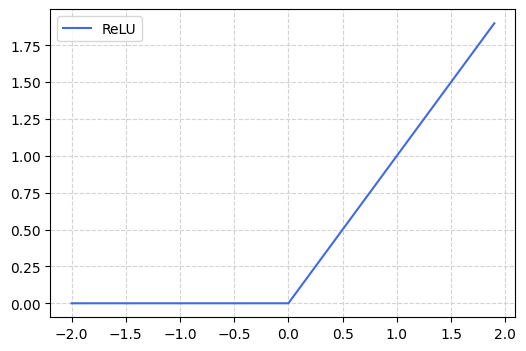

In [68]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(x, relu_x.numpy(), color="royalblue", label="ReLU")
ax.legend()
ax.grid(True, linestyle="--", color="lightgrey")

ReLU can be thought of as a “ramp function”: it is a straight line with slope $m=1$ for positive inputs, while it outputs zero for negative inputs. It is a simple nonlinear function, very fast to compute, and in most cases sufficient to introduce the necessary non-linearity into the model. Let's build again our model introducing ReLU layers:

In [95]:
# Building a simple Neural Network for classification
class CircleModel_v1(nn.Module):
    def __init__(self):
        # inheritance from nn.Module 
        super().__init__()

        # Defining layers as class attributes
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # take 2 input features and output 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # take 10 input features and output 10 feature (y)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

        
    # Define the forward method
    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [96]:
# 4. Create an instance of the model and send it to target device
circlemodel_v1 = CircleModel_v1().to(device)

In [97]:
# Setup loss and optimizer 
loss_fn_v1 = nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(circlemodel_v1.parameters(), lr=0.1)

In [98]:
# TRAINING LOOP
epochs = 2000
torch.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### TRAINING

    # This command put the model in training mode
    circlemodel_v1.train()

    # 1. Pass the training data through the forward() method of the model
    y_logits = circlemodel_v1(X_train).squeeze() # squeeze to remove the extra dimension
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss and accuract
    loss = loss_fn_v1(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_preds) 

    # 3. Zero grad of the optimizer --> we zero the gradients since they accumalate at each epochs
    optimizer_v1.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Progress the optimizer
    optimizer_v1.step()

    ### TESTING
    # Put the model in evaluation mode
    circlemodel_v1.eval()

    # Make the inference
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_logits = circlemodel_v1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_preds)

        # Print out what's happening every 10 epochs
        if epoch % 200 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 97.75% | Test loss: 0.40595, Test acc: 92.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 99.50% | Test loss: 0.22108, Test acc: 97.50%
Epoch: 1600 | Loss: 0.09123, Accuracy: 99.88% | Test loss: 0.12741, Test acc: 99.50%
Epoch: 1800 | Loss: 0.05773, Accuracy: 99.88% | Test loss: 0.08672, Test acc: 99.50%


Wow, now the test accuracy is far better than before!

In [99]:
# Get model predictions (logits → sigmoid → probabilities)
with torch.no_grad():
    point_preds = torch.sigmoid(circlemodel_v1(grid_tensor)).to("cpu").numpy().reshape(xx.shape)

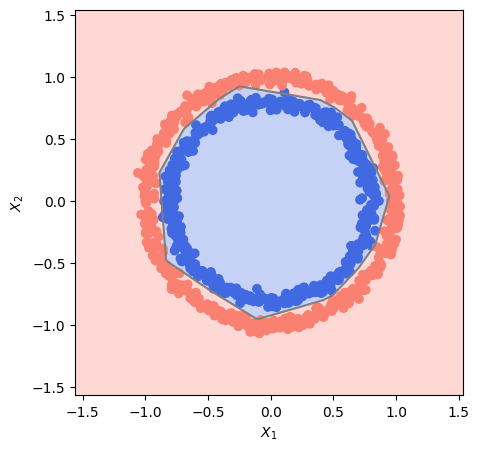

In [100]:
# Plot the decision regions
fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(xx, yy, point_preds, levels=[0, 0.5, 1], alpha=0.3, colors=["salmon", "royalblue"])

# Also plot the decision boundary line (at probability = 0.5)
ax.contour(xx, yy, point_preds, levels=[0.5], colors="grey", linewidths=1.5)

ax.scatter(df_circles["X_1"], df_circles["X_2"], c=df_circles["label"].map(lambda x: "royalblue" if x == 1 else "salmon"))
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
plt.show()